### Продакт-менеджер Василий попросил вас проанализировать совершенные покупки и ответить на следующие вопросы:

1. Сколько у нас пользователей, которые совершили покупку только один раз?  

2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)? 

3. По каждому товару определить, в какой день недели товар чаще всего покупается. 

4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть. 

#### Файлы:
        
        olist_customers_datase.csv  — таблица с уникальными идентификаторами пользователей
customer_id — позаказный идентификатор пользователя

customer_unique_id —  уникальный идентификатор пользователя  (в идеальных данных не может быть двух пользователей с одинаковым значением, является уникальным айдишником пользователя)

customer_zip_code_prefix —  почтовый индекс пользователя

customer_city —  город доставки пользователя

customer_state —  штат доставки пользователя

        olist_orders_dataset.csv —  таблица заказов
order_id —  уникальный идентификатор заказа (номер чека)

customer_id —  позаказный идентификатор пользователя

order_status —  статус заказа

order_purchase_timestamp —  время создания заказа

order_approved_at —  время подтверждения оплаты заказа

order_delivered_carrier_date —  время передачи заказа в логистическую службу

order_delivered_customer_date —  время доставки заказа

order_estimated_delivery_date —  обещанная дата доставки

        olist_order_items_dataset.csv —  товарные позиции, входящие в заказы
order_id —  уникальный идентификатор заказа (номер чека)

order_item_id —  идентификатор товара внутри одного заказа (не содержит информацию о количестве товаров)

product_id —  уникальный идентефикатор товара (аналог штрихкода)

seller_id — уникальный идентефикатор производителя товара

shipping_limit_date —  максимальная дата доставки продавцом для передачи заказа партнеру по логистике

price —  цена за единицу товара

freight_value —  вес товара

— Пример структуры данных можно визуализировать по order_id == 00143d0f86d6fbd9f9b38ab440ac16f5

#### Уникальные статусы заказов в таблице olist_orders_dataset:

created —  создан
approved —  подтверждён
invoiced —  выставлен счёт
processing —  в процессе сборки заказа
shipped —  отгружен со склада
delivered —  доставлен пользователю
unavailable —  недоступен
canceled —  отменён

In [83]:
import pandas as pd
import seaborn as sns
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

Посмотрим на данные, типы данных, кол-во уникальных значений и проверим есть ли отсутствующие значения

In [84]:
customers = pd.read_csv('olist_customers_dataset.csv')
customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [85]:
customers.shape

(99441, 5)

In [86]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


In [87]:
customers.isna().sum()

customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

In [88]:
customers.nunique()

customer_id                 99441
customer_unique_id          96096
customer_zip_code_prefix    14994
customer_city                4119
customer_state                 27
dtype: int64

In [89]:
orders = pd.read_csv('olist_orders_dataset.csv', 
                     parse_dates=['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 
                                  'order_delivered_customer_date', 'order_estimated_delivery_date'])
orders
# сразу меняю тип данных 

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26
...,...,...,...,...,...,...,...,...
99436,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28
99437,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02
99438,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27
99439,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15


In [90]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99441 non-null  object        
 1   customer_id                    99441 non-null  object        
 2   order_status                   99441 non-null  object        
 3   order_purchase_timestamp       99441 non-null  datetime64[ns]
 4   order_approved_at              99281 non-null  datetime64[ns]
 5   order_delivered_carrier_date   97658 non-null  datetime64[ns]
 6   order_delivered_customer_date  96476 non-null  datetime64[ns]
 7   order_estimated_delivery_date  99441 non-null  datetime64[ns]
dtypes: datetime64[ns](5), object(3)
memory usage: 6.1+ MB


In [91]:
orders.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

In [92]:
orders.nunique()

order_id                         99441
customer_id                      99441
order_status                         8
order_purchase_timestamp         98875
order_approved_at                90733
order_delivered_carrier_date     81018
order_delivered_customer_date    95664
order_estimated_delivery_date      459
dtype: int64

In [93]:
order_items = pd.read_csv('olist_order_items_dataset.csv', parse_dates=['shipping_limit_date'])
order_items

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14
...,...,...,...,...,...,...,...
112645,fffc94f6ce00a00581880bf54a75a037,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-05-02 04:11:01,299.99,43.41
112646,fffcd46ef2263f404302a634eb57f7eb,1,32e07fd915822b0765e448c4dd74c828,f3c38ab652836d21de61fb8314b69182,2018-07-20 04:31:48,350.00,36.53
112647,fffce4705a9662cd70adb13d4a31832d,1,72a30483855e2eafc67aee5dc2560482,c3cfdc648177fdbbbb35635a37472c53,2017-10-30 17:14:25,99.90,16.95
112648,fffe18544ffabc95dfada21779c9644f,1,9c422a519119dcad7575db5af1ba540e,2b3e4a2a3ea8e01938cabda2a3e5cc79,2017-08-21 00:04:32,55.99,8.72


In [94]:
order_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   order_id             112650 non-null  object        
 1   order_item_id        112650 non-null  int64         
 2   product_id           112650 non-null  object        
 3   seller_id            112650 non-null  object        
 4   shipping_limit_date  112650 non-null  datetime64[ns]
 5   price                112650 non-null  float64       
 6   freight_value        112650 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 6.0+ MB


In [95]:
order_items.isna().sum()

order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64

In [96]:
order_items.nunique()

order_id               98666
order_item_id             21
product_id             32951
seller_id               3095
shipping_limit_date    93318
price                   5968
freight_value           6999
dtype: int64

## 1. Сколько у нас пользователей, которые совершили покупку только один раз? 

объединим таблицы покупателей и заказов по customer_id - позаказный идентификатор пользователя

In [97]:
customers_and_orders = customers.merge(orders, how='inner', on='customer_id')

In [98]:
customers_and_orders.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15


покупкой буду считать заказы со статусом delivered и присутствующей датой доставки(order_delivered_customer_date).
canceled не учитываем, так как это отмена заказа. 
Остальные статусы заказа не считаю покупкой, так как время доставки заказа(order_delivered_customer_date) 
у них отсутствует.

In [99]:
customers_and_orders[['customer_unique_id','order_status', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date']]\
    .groupby(['order_status'],as_index=False)\
    .count()

,order_status,customer_unique_id,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date
0,approved,2,2,0,0
1,canceled,625,484,75,6
2,created,5,0,0,0
3,delivered,96478,96464,96476,96470
4,invoiced,314,314,0,0
5,processing,301,301,0,0
6,shipped,1107,1107,1107,0
7,unavailable,609,609,0,0


In [100]:
purchases = customers_and_orders \
                .query('order_status == "delivered"') \
                .fillna(0) \
                .query('order_delivered_customer_date != 0')
purchases # покупки
# заменяем NaN на 0 и ищем заказы с order_delivered_customer_date не равным 0

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15
...,...,...,...,...,...,...,...,...,...,...,...,...
99436,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,3937,sao paulo,SP,6760e20addcf0121e9d58f2f1ff14298,delivered,2018-04-07 15:48:17,2018-04-07 16:08:45,2018-04-11 02:08:36,2018-04-13 20:06:37,2018-04-25
99437,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,6764,taboao da serra,SP,9ec0c8947d973db4f4e8dcf1fbfa8f1b,delivered,2018-04-04 08:20:22,2018-04-04 08:35:12,2018-04-05 18:42:35,2018-04-11 18:54:45,2018-04-20
99438,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,60115,fortaleza,CE,fed4434add09a6f332ea398efd656a5c,delivered,2018-04-08 20:11:50,2018-04-08 20:30:03,2018-04-09 17:52:17,2018-05-09 19:03:15,2018-05-02
99439,56b18e2166679b8a959d72dd06da27f9,73c2643a0a458b49f58cea58833b192e,92120,canoas,RS,e31ec91cea1ecf97797787471f98a8c2,delivered,2017-11-03 21:08:33,2017-11-03 21:31:20,2017-11-06 18:24:41,2017-11-16 19:58:39,2017-12-05


группируем покупки по customer_unique_id отбираем те, где кол-во заказов равно 1

In [101]:
purchases \
    .groupby('customer_unique_id') \
    .agg({'customer_id': 'count'}) \
    .query('customer_id == 1')

,customer_id
customer_unique_id,
0000366f3b9a7992bf8c76cfdf3221e2,1
0000b849f77a49e4a4ce2b2a4ca5be3f,1
0000f46a3911fa3c0805444483337064,1
0000f6ccb0745a6a4b88665a16c9f078,1
0004aac84e0df4da2b147fca70cf8255,1
...,...
fffcf5a5ff07b0908bd4e2dbc735a684,1
fffea47cd6d3cc0a88bd621562a9d061,1
ffff371b4d645b6ecea244b27531430a,1


Ответ: 90549 пользователей совершили 1 покупку 

## 2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)? 

In [102]:
customers_and_orders['order_purchase_timestamp'] = customers_and_orders.order_purchase_timestamp.dt.strftime('%Y-%m')
#привожу данные к месяцу

In [103]:
customers_and_orders

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15
...,...,...,...,...,...,...,...,...,...,...,...,...
99436,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,3937,sao paulo,SP,6760e20addcf0121e9d58f2f1ff14298,delivered,2018-04,2018-04-07 16:08:45,2018-04-11 02:08:36,2018-04-13 20:06:37,2018-04-25
99437,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,6764,taboao da serra,SP,9ec0c8947d973db4f4e8dcf1fbfa8f1b,delivered,2018-04,2018-04-04 08:35:12,2018-04-05 18:42:35,2018-04-11 18:54:45,2018-04-20
99438,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,60115,fortaleza,CE,fed4434add09a6f332ea398efd656a5c,delivered,2018-04,2018-04-08 20:30:03,2018-04-09 17:52:17,2018-05-09 19:03:15,2018-05-02
99439,56b18e2166679b8a959d72dd06da27f9,73c2643a0a458b49f58cea58833b192e,92120,canoas,RS,e31ec91cea1ecf97797787471f98a8c2,delivered,2017-11,2017-11-03 21:31:20,2017-11-06 18:24:41,2017-11-16 19:58:39,2017-12-05


находим сколько в среднем недоставленных заказов 

In [104]:
undelivered = customers_and_orders \
                .fillna(0) \
                .query('order_status == "delivered" and order_delivered_customer_date == 0 or order_status != "delivered"') \
                .groupby(['order_purchase_timestamp', 'order_status'], as_index=False) \
                .agg({'order_id': 'count'}) \
                .groupby('order_status').agg({'order_id': 'mean'}) \
                .rename(index={'delivered':'not_delivered'}) \
                .rename(columns={'order_id':'avg'}) \
                .sort_values('avg', ascending=False)
undelivered # недоставленные заказы

,avg
order_status,
shipped,48.130435
unavailable,29.000000
canceled,26.041667
processing,15.842105
invoiced,14.952381
not_delivered,2.000000
created,1.666667
approved,1.000000


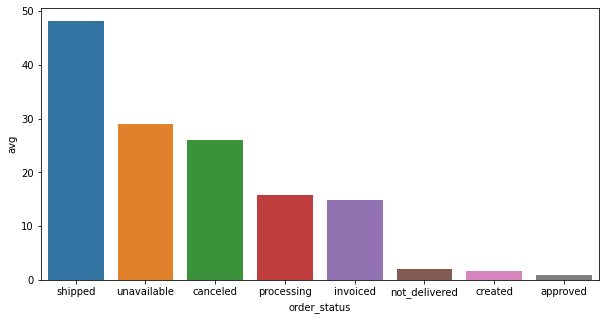

In [105]:
plt.figure(figsize=(10,5))
ax = sns.barplot(data=undelivered, y='avg', x=undelivered.index)

Классифицируем причины на основании данных в столбцах:
    order_status(статус заказа)
    order_approved_at(время подтверждения оплаты заказа)
    order_delivered_carrier_date( время передачи заказа в логистическую службу)
    order_delivered_customer_date(время доставки заказа)
    order_id(уникальный идентификатор заказа)

In [106]:
customers_and_orders[['order_id','order_status', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date']]\
    .fillna(0) \
    .query('order_status == "delivered" and order_delivered_customer_date == 0 or order_status != "delivered"')\
    .groupby(['order_status'],as_index=False).count()

,order_status,order_id,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date
0,approved,2,2,2,2
1,canceled,625,625,625,625
2,created,5,5,5,5
3,delivered,8,8,8,8
4,invoiced,314,314,314,314
5,processing,301,301,301,301
6,shipped,1107,1107,1107,1107
7,unavailable,609,609,609,609


Проанализируем полученные данные: 
рассмотрим статусы: 
approved, invoiced, processing-все заказы были оплачены, но продавец не доставил товар в логистическую службу 
и тем самым заказ был недоставлен покупателю. Объеденим данные статусы под одну причину"заказ не отправлен продавцом"
shipped объединим с 8ю заказами delivered, у которых нет данных по дате доставки, в группу - "логист.служба не отправила 
заказ покупателю". Так как данные заказы были доставлены в логист.службу, но она не отправила заказ покупателю.
unavailable - товар не доступен, когда товара нет в наличии. Также данный статус можно охарактеризовать как системный сбой
так как его успели заказать и оплатить(было наличие товара на сайте).
created- заказ не был оплачен покупателем.
canceled - заказ отменен на разных стадиях.

In [107]:
customers_and_orders.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15


In [108]:
customers_and_orders['reasons'] = customers_and_orders['order_status']

In [109]:
customers_and_orders.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,reasons
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,delivered
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,delivered
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13,delivered
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10,delivered
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15,delivered


In [110]:
customers_and_orders.loc[(customers_and_orders.order_delivered_customer_date.isna()) & 
                         (customers_and_orders.reasons.str.contains('delivered')), 'reasons'] = 'not_delivered'

In [111]:
customers_and_orders.reasons.value_counts()

delivered        96470
shipped           1107
canceled           625
unavailable        609
invoiced           314
processing         301
not_delivered        8
created              5
approved             2
Name: reasons, dtype: int64

In [112]:
customers_and_orders['reasons'] = customers_and_orders['reasons'] \
        .replace({'created': 'Заказ не оплачен', 'approved': 'Заказ не отправлен продавцом', 
                  'invoiced': 'Заказ не отправлен продавцом', 'processing': 'Заказ не отправлен продавцом', 
                  'canceled': 'Отменен', 'unavailable': 'Нет в наличии', 'shipped': 'Заказ недоставлен логистической службой', 
                  'not_delivered': 'Заказ недоставлен логистической службой'})

In [113]:
customers_and_orders.reasons.value_counts()

delivered                                  96470
Заказ недоставлен логистической службой     1115
Отменен                                      625
Заказ не отправлен продавцом                 617
Нет в наличии                                609
Заказ не оплачен                               5
Name: reasons, dtype: int64

In [114]:
customers_and_orders.shape

(99441, 13)

In [115]:
avg_reasons = customers_and_orders\
    .query('reasons != "delivered"')\
    .groupby(['order_purchase_timestamp','reasons'],as_index=False)['order_id'].count()\
    .groupby('reasons',as_index=False).mean()\
    .rename(columns={'order_id':'avg'})\
    .sort_values('avg')

In [116]:
avg_reasons

,reasons,avg
0,Заказ не оплачен,1.666667
4,Отменен,26.041667
3,Нет в наличии,29.000000
1,Заказ не отправлен продавцом,29.380952
2,Заказ недоставлен логистической службой,48.478261


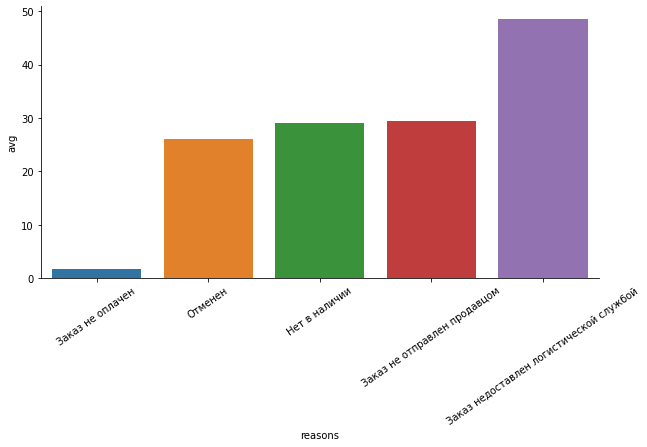

In [117]:
plt.figure(figsize=(10,5))
ax = sns.barplot(data=avg_reasons, y='avg', x='reasons')
ax.set_xticklabels(avg_reasons.reasons, rotation=35)
sns.despine()

Вывод: компании стоит рассмотреть другие логистические службы для доставки заказа покупателю,
так большая часть заказов в месяц в среднем не доставляется по их причине.
Необходимо пересмотреть внутреннюю организацию обработки, доставки заказов в логистическую службу, 
а также следить за актуальностью информации в интернет магазине

## 3. По каждому товару определить, в какой день недели товар чаще всего покупается. 

In [118]:
purchases_and_orders = orders.merge(order_items, how='inner', on='order_id')

In [119]:
purchases_and_orders = purchases_and_orders \
                                    .query('order_status == "delivered"') \
                                    .fillna(0) \
                                    .query('order_delivered_customer_date != 0') 
# отобрали покупки

In [120]:
purchases_and_orders

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,1,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,1,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,1,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,1,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112645,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02,1,f1d4ce8c6dd66c47bbaa8c6781c2a923,1f9ab4708f3056ede07124aad39a2554,2018-02-12 13:10:37,174.90,20.10
112646,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27,1,b80910977a37536adeddd63663f916ad,d50d79cb34e38265a8649c383dcffd48,2017-09-05 15:04:16,205.99,65.02
112647,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15,1,d1c427060a0f73f6b889a5c7c61f2ac4,a1043bafd471dff536d0c462352beb48,2018-01-12 21:36:21,179.99,40.59
112648,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15,2,d1c427060a0f73f6b889a5c7c61f2ac4,a1043bafd471dff536d0c462352beb48,2018-01-12 21:36:21,179.99,40.59


In [121]:
purchases_and_orders['day_of_week'] = purchases_and_orders.order_purchase_timestamp.dt.strftime('%A')
# узнаем в какой день недели сделана покупка

In [122]:
purchases_of_day = purchases_and_orders \
    .groupby(['product_id', 'day_of_week'], as_index=False) \
    .agg({'customer_id': 'count'}) \
    .rename(columns={'customer_id': 'purchases'}) \
    .sort_values('purchases', ascending=False)
purchases_of_day

,product_id,day_of_week,purchases
15595,422879e10f46682990de24d770e7f83d,Wednesday,93
35749,99a4788cb24856965c36a24e339b6058,Monday,91
40180,aca2eb7d00ea1a7b8ebd4e68314663af,Thursday,89
40181,aca2eb7d00ea1a7b8ebd4e68314663af,Tuesday,85
40176,aca2eb7d00ea1a7b8ebd4e68314663af,Friday,83
...,...,...,...
23489,6413f8d0daa3a38887a14917589e7da5,Wednesday,1
23491,641444946fe3a839d726c32804cd1aff,Tuesday,1
23492,6416e0ecd625ef4adf18658a9aca2e10,Thursday,1
23493,64187b994e1b15e6a59a6f72688fbea8,Friday,1


Для того чтобы по каждому товару определить в какой день недели товар чаще всего покупается, 
необходимо найти максимальные значения по "product_id" в столбце "purchases"
и при этом не потерять значения столбца "day_of_week"
Посчитаем отдельно максимальные значения "max_purchase" для каждого "product_id" по столбцу "purchases"
Далее полученные данные мы добавим в основной датафрейм "purchases_of_day" 
и посчитаем разницу между столбцами(difference) max и purchases.
Нулевые значения в столбце difference и будут максимальными значениями покупок по дням недели(max.знач - max.знач дает нам 0)

In [123]:
max_purchase = purchases_of_week.groupby(['product_id'],as_index=False) \
  .agg({'purchases':'max'})\
  .rename(columns={'purchases':'max'})# max значения для product_id
max_purchase

,product_id,max
0,00066f42aeeb9f3007548bb9d3f33c38,1
1,00088930e925c41fd95ebfe695fd2655,1
2,0009406fd7479715e4bef61dd91f2462,1
3,000b8f95fcb9e0096488278317764d19,1
4,000d9be29b5207b54e86aa1b1ac54872,1
...,...,...
32209,fff6177642830a9a94a0f2cba5e476d1,1
32210,fff81cc3158d2725c0655ab9ba0f712c,1
32211,fff9553ac224cec9d15d49f5a263411f,1
32212,fffdb2d0ec8d6a61f0a0a0db3f25b441,2


In [124]:
purchase_day_merge = purchases_of_day.merge(max_purchase, how='inner', on=['product_id'])
#добавляем в основной датафрейм "product_purchase_day"
purchase_day_merge

,product_id,day_of_week,purchases,max
0,422879e10f46682990de24d770e7f83d,Wednesday,93,93
1,422879e10f46682990de24d770e7f83d,Thursday,79,93
2,422879e10f46682990de24d770e7f83d,Friday,77,93
3,422879e10f46682990de24d770e7f83d,Tuesday,67,93
4,422879e10f46682990de24d770e7f83d,Monday,64,93
...,...,...,...,...
59944,64123627d4116a2bc8284f1bc0a257f3,Saturday,1,1
59945,6413f8d0daa3a38887a14917589e7da5,Wednesday,1,1
59946,641444946fe3a839d726c32804cd1aff,Tuesday,1,1
59947,6416e0ecd625ef4adf18658a9aca2e10,Thursday,1,1


Считаем разницу между столбцами(difference) max и purchases 

In [125]:
purchase_day_merge['difference']= purchase_day_merge['max']-purchase_day_merge['purchases']

Ответ

In [126]:
purchase_day_merge.query('difference == 0')[['product_id','day_of_week']]

,product_id,day_of_week
0,422879e10f46682990de24d770e7f83d,Wednesday
7,99a4788cb24856965c36a24e339b6058,Monday
14,aca2eb7d00ea1a7b8ebd4e68314663af,Thursday
21,53b36df67ebb7c41585e8d54d6772e08,Tuesday
28,389d119b48cf3043d311335e499d9c6b,Thursday
...,...,...
59944,64123627d4116a2bc8284f1bc0a257f3,Saturday
59945,6413f8d0daa3a38887a14917589e7da5,Wednesday
59946,641444946fe3a839d726c32804cd1aff,Tuesday
59947,6416e0ecd625ef4adf18658a9aca2e10,Thursday


## 4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть.  

In [127]:
customers_and_orders_2 = customers.merge(orders, how='inner', on='customer_id')

In [128]:
customers_and_orders_2['month'] = customers_and_orders_2.order_purchase_timestamp.dt.month_name()
customers_and_orders_2

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,month
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,May
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,January
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13,May
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10,March
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15,July
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99436,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,3937,sao paulo,SP,6760e20addcf0121e9d58f2f1ff14298,delivered,2018-04-07 15:48:17,2018-04-07 16:08:45,2018-04-11 02:08:36,2018-04-13 20:06:37,2018-04-25,April
99437,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,6764,taboao da serra,SP,9ec0c8947d973db4f4e8dcf1fbfa8f1b,delivered,2018-04-04 08:20:22,2018-04-04 08:35:12,2018-04-05 18:42:35,2018-04-11 18:54:45,2018-04-20,April
99438,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,60115,fortaleza,CE,fed4434add09a6f332ea398efd656a5c,delivered,2018-04-08 20:11:50,2018-04-08 20:30:03,2018-04-09 17:52:17,2018-05-09 19:03:15,2018-05-02,April
99439,56b18e2166679b8a959d72dd06da27f9,73c2643a0a458b49f58cea58833b192e,92120,canoas,RS,e31ec91cea1ecf97797787471f98a8c2,delivered,2017-11-03 21:08:33,2017-11-03 21:31:20,2017-11-06 18:24:41,2017-11-16 19:58:39,2017-12-05,November


считаем сколько недель в месяце

In [129]:
customers_and_orders_2['weeks_in_month'] = customers_and_orders_2.order_purchase_timestamp.dt.days_in_month / 7

In [130]:
customers_and_orders_2

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,month,weeks_in_month
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,May,4.428571
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,January,4.428571
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13,May,4.428571
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10,March,4.428571
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15,July,4.428571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99436,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,3937,sao paulo,SP,6760e20addcf0121e9d58f2f1ff14298,delivered,2018-04-07 15:48:17,2018-04-07 16:08:45,2018-04-11 02:08:36,2018-04-13 20:06:37,2018-04-25,April,4.285714
99437,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,6764,taboao da serra,SP,9ec0c8947d973db4f4e8dcf1fbfa8f1b,delivered,2018-04-04 08:20:22,2018-04-04 08:35:12,2018-04-05 18:42:35,2018-04-11 18:54:45,2018-04-20,April,4.285714
99438,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,60115,fortaleza,CE,fed4434add09a6f332ea398efd656a5c,delivered,2018-04-08 20:11:50,2018-04-08 20:30:03,2018-04-09 17:52:17,2018-05-09 19:03:15,2018-05-02,April,4.285714
99439,56b18e2166679b8a959d72dd06da27f9,73c2643a0a458b49f58cea58833b192e,92120,canoas,RS,e31ec91cea1ecf97797787471f98a8c2,delivered,2017-11-03 21:08:33,2017-11-03 21:31:20,2017-11-06 18:24:41,2017-11-16 19:58:39,2017-12-05,November,4.285714


считаем среднее число заказов в месяц

In [131]:
customer_by_month = customers_and_orders_2 \
                .query('order_status == "delivered"') \
                .fillna(0) \
                .query('order_delivered_customer_date != 0') \
                .groupby(['customer_unique_id','month','weeks_in_month'], as_index=False) \
                .agg({'order_status':'count'}) \
                .groupby(['customer_unique_id','month','weeks_in_month'],as_index=False) \
                .agg({'order_status':'mean'}) \
                .rename(columns={'order_status':'avg_by_month'})

In [132]:
customer_by_month

,customer_unique_id,month,weeks_in_month,avg_by_month
0,0000366f3b9a7992bf8c76cfdf3221e2,May,4.428571,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,May,4.428571,1
2,0000f46a3911fa3c0805444483337064,March,4.428571,1
3,0000f6ccb0745a6a4b88665a16c9f078,October,4.428571,1
4,0004aac84e0df4da2b147fca70cf8255,November,4.285714,1
...,...,...,...,...
95142,fffcf5a5ff07b0908bd4e2dbc735a684,June,4.285714,1
95143,fffea47cd6d3cc0a88bd621562a9d061,December,4.428571,1
95144,ffff371b4d645b6ecea244b27531430a,February,4.000000,1
95145,ffff5962728ec6157033ef9805bacc48,May,4.428571,1


 Рассчитаем среднее количество покупок в неделю по месяцам

In [133]:
customer_by_month['avg_purchases_per_week_by_month'] = customer_by_month.avg_by_month / customer_by_month.weeks_in_month
customer_by_month

,customer_unique_id,month,weeks_in_month,avg_by_month,avg_purchases_per_week_by_month
0,0000366f3b9a7992bf8c76cfdf3221e2,May,4.428571,1,0.225806
1,0000b849f77a49e4a4ce2b2a4ca5be3f,May,4.428571,1,0.225806
2,0000f46a3911fa3c0805444483337064,March,4.428571,1,0.225806
3,0000f6ccb0745a6a4b88665a16c9f078,October,4.428571,1,0.225806
4,0004aac84e0df4da2b147fca70cf8255,November,4.285714,1,0.233333
...,...,...,...,...,...
95142,fffcf5a5ff07b0908bd4e2dbc735a684,June,4.285714,1,0.233333
95143,fffea47cd6d3cc0a88bd621562a9d061,December,4.428571,1,0.225806
95144,ffff371b4d645b6ecea244b27531430a,February,4.000000,1,0.250000
95145,ffff5962728ec6157033ef9805bacc48,May,4.428571,1,0.225806
